_Lambda School Data Science — Regression 2_ 

This sprint, your project is Caterpillar Tube Pricing: Predict the prices suppliers will quote for industrial tube assemblies.

# Gradient Boosting, More Feature Engineering


#### Objectives
- Do feature engineering with relational data
- Use xgboost for gradient boosting

#### Python libraries for Gradient Boosting
- [scikit-learn Gradient Tree Boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting) — slower than other libraries, but [the new version may be better](https://twitter.com/amuellerml/status/1129443826945396737)
  - Anaconda: already installed
  - Google Colab: already installed
- [xgboost](https://xgboost.readthedocs.io/en/latest/) — can accept missing values and enforce [monotonic constraints](https://xiaoxiaowang87.github.io/monotonicity_constraint/)
  - Anaconda, Mac/Linux: `conda install -c conda-forge xgboost`
  - Windows: `conda install -c anaconda py-xgboost`
  - Google Colab: already installed
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/) — can accept missing values and enforce [monotonic constraints](https://blog.datadive.net/monotonicity-constraints-in-machine-learning/)
  - Anaconda: `conda install -c conda-forge lightgbm`
  - Google Colab: already installed
- [CatBoost](https://catboost.ai/) — can accept missing values and use [categorical features](https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html) without preprocessing
  - Anaconda: `conda install -c conda-forge catboost`
  - Google Colab: `pip install catboost`

### Get data


#### Option 1. Kaggle web UI
 
Sign in to Kaggle and go to the [Caterpillar Tube Pricing](https://www.kaggle.com/c/caterpillar-tube-pricing) competition. Go to the Data page. After you have accepted the rules of the competition, use the download buttons to download the data.


#### Option 2. Kaggle API

Follow these [instructions](https://github.com/Kaggle/kaggle-api).

#### Option 3. Google Drive

Download [zip file](https://drive.google.com/uc?export=download&id=1oGky3xR6133pub7S4zIEFbF4x1I87jvC) from Google Drive.

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# !unzip caterpillar-tube-pricing.zip

In [ ]:
# !unzip data.zip

## Do feature engineering with relational data

Here are some questions — not answers!

### `bill_of_materials`

is formatted like this:

In [3]:
import pandas as pd
materials = pd.read_csv('competition_data/bill_of_materials.csv')
materials.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
materials.isnull().sum() / len(materials)

tube_assembly_id    0.000000
component_id_1      0.096660
quantity_1          0.096660
component_id_2      0.302481
quantity_2          0.302481
component_id_3      0.773988
quantity_3          0.773658
component_id_4      0.971365
quantity_4          0.971318
component_id_5      0.995660
quantity_5          0.995660
component_id_6      0.998773
quantity_6          0.998773
component_id_7      0.999670
quantity_7          0.999670
component_id_8      0.999953
quantity_8          0.999953
dtype: float64

#### Would this be a better representation?

Could pandas melt, crosstab, and other functions help reshape the data like this?

| Crosstab | C-1622 | C-1629 | C-1312 | C-1624 | C-1631 | C-1641 | Distinct | Total |
|:--------:|:------:|--------|--------|--------|--------|--------|----------|-------|
| TA-00001 | 2      | 2      | 0      | 0      | 0      | 0      | 2        | 4     |
| TA-00002 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00003 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00004 | 0      | 0      | 2      | 0      | 0      | 0      | 1        | 2     |
| TA-00005 | 0      | 0      | 0      | 1      | 1      | 1      | 3        | 3     |

### `components`

Contains three representations of each component, in order of decreasing cardinality / granularity:

- `component_id`
- `name`
- `component_type_id`

What are the pros & cons of these different representations?

In [5]:
components = pd.read_csv('competition_data/components.csv')
components.describe()

,component_id,name,component_type_id
count,2048,2047,2048
unique,2048,297,29
top,C-0895,FLANGE,OTHER
freq,1,350,1006


## Example solution for last assignment 🚜

In [6]:
# !pip install category_encoders

In [7]:
import category_encoders as ce
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge tube data
    tube = pd.read_csv('competition_data/tube.csv')
    X = X.merge(tube, how='left')
    
    # Engineer features from bill_of_materials
    materials = pd.read_csv('competition_data/bill_of_materials.csv')
    
    materials['components_total'] = (materials['quantity_1'].fillna(0) + 
                                     materials['quantity_2'].fillna(0) + 
                                     materials['quantity_3'].fillna(0) + 
                                     materials['quantity_4'].fillna(0) + 
                                     materials['quantity_5'].fillna(0) + 
                                     materials['quantity_6'].fillna(0) + 
                                     materials['quantity_7'].fillna(0) + 
                                     materials['quantity_8'].fillna(0))

    materials['components_distinct'] = (materials['component_id_1'].notnull().astype(int) + 
                                        materials['component_id_2'].notnull().astype(int) + 
                                        materials['component_id_3'].notnull().astype(int) + 
                                        materials['component_id_4'].notnull().astype(int) + 
                                        materials['component_id_5'].notnull().astype(int) + 
                                        materials['component_id_6'].notnull().astype(int) + 
                                        materials['component_id_7'].notnull().astype(int) + 
                                        materials['component_id_8'].notnull().astype(int))
    
    # Merge selected features from bill_of_materials
    # Just use the first component_id, ignore the others for now!
    features = ['tube_assembly_id', 'component_id_1', 'components_total', 'components_distinct']
    X = X.merge(materials[features], how='left')
    
    # Get component_type_id (has lower cardinality than component_id)
    components = pd.read_csv('competition_data/components.csv')
    components = components.rename(columns={'component_id': 'component_id_1'})
    features = ['component_id_1', 'component_type_id']
    X = X.merge(components[features], how='left')
    
    # Count the number of specs for the tube assembly
    specs = pd.read_csv('competition_data/specs.csv')
    specs['specs_total'] = specs.drop(columns=['tube_assembly_id']).count(axis=1)
    features = ['tube_assembly_id', 'specs_total', 'spec1']
    X = X.merge(specs[features], how='left')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    return X


# Read data
trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

# Split into train & validation sets
# All rows for a given tube_assembly_id should go in either train or validation
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

# Wrangle train, validation, and test sets
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange X matrix and y vector (log-transformed)
target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

# Predict
def generate_submission(estimator, X_test, filename):
    y_pred_log = estimator.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
    submission = pd.read_csv('sample_submission.csv')
    submission['cost'] = y_pred
    submission.to_csv(filename, index=False)
    
generate_submission(pipeline, X_test, 'submission-02.csv')

Validation Error 0.2946234726396677


In [8]:
print(pipeline)

Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['supplier', 'bracket_pricing', 'material_id', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x', 'component_id_1', 'component_type_id', 'spec1'],
        drop_invariant=False, handle_missing='value',
        handle_unknown='value',
      ...imators=1000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])


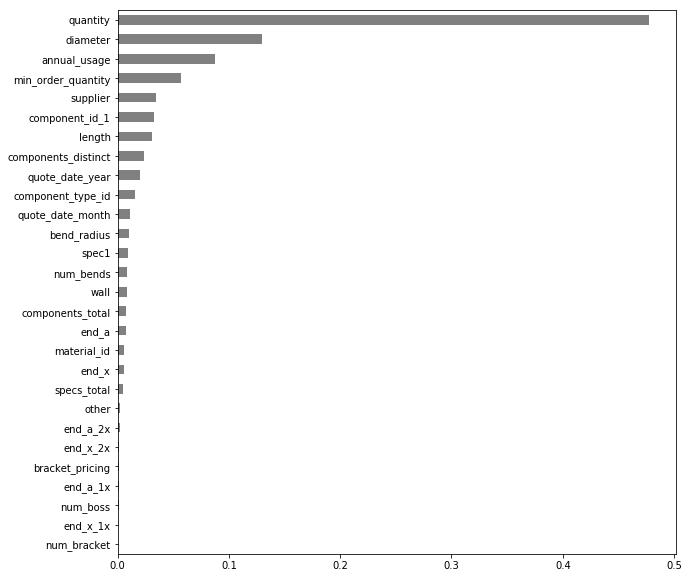

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

## Use xgboost for gradient boosting

#### [XGBoost Python API Reference: Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [3]:
# !pip install xgboost

  Using cached https://files.pythonhosted.org/packages/96/84/4e2cae6247f397f83d8adc5c2a2a0c5d7d790a14a4c7400ff6574586f589/xgboost-0.90.tar.gz
  Stored in directory: /Users/dwightchurchill/Library/Caches/pip/wheels/e9/48/4d/de4187b5270dff71d3697c5a7857a1e2d9a0c63a28b3462eeb
Successfully built xgboost
Error checking for conflicts.
Traceback (most recent call last):
  File "/Users/dwightchurchill/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2897, in _dep_map
    return self.__dep_map
  File "/Users/dwightchurchill/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2691, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/dwightchurchill/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2888, in _parsed_pkg_info
    return self._p

In [4]:
%%time 

from gxboost import XGBRegressor
pipeline = make_pipeline(ce.OrdinalEncoder(), XGBRegressor(n_jobs=-1))
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

ModuleNotFoundError: No module named 'gxboost'

#### Jason Brownlee, [Avoid Overfitting By Early Stopping With XGBoost In Python](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)

In [ ]:
import category_encoders as ce
from 

### Understand the difference between boosting & bagging

Boosting (used by Gradient Boosting) is different than Bagging (used by Random Forests). 

[_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8.2.3, Boosting:

>Recall that bagging involves creating multiple copies of the original training data set using the bootstrap, fitting a separate decision tree to each copy, and then combining all of the trees in order to create a single predictive model.

>**Boosting works in a similar way, except that the trees are grown _sequentially_: each tree is grown using information from previously grown trees.**

>Unlike fitting a single large decision tree to the data, which amounts to _fitting the data hard_ and potentially overfitting, the boosting approach instead _learns slowly._ Given the current model, we fit a decision tree to the residuals from the model.

>We then add this new decision tree into the fitted function in order to update the residuals. Each of these trees can be rather small, with just a few terminal nodes. **By fitting small trees to the residuals, we slowly improve fˆ in areas where it does not perform well.**

>Note that in boosting, unlike in bagging, the construction of each tree depends strongly on the trees that have already been grown.

# Assignment
- Continue to participate in the [Kaggle Caterpillar competition](https://www.kaggle.com/c/caterpillar-tube-pricing).
- Do more feature engineering. 
- Use xgboost for gradient boosting.
- Submit new predictions.
- Commit your notebook to your fork of the GitHub repo.

## Stretch Goals
- Improve your scores on Kaggle.
- Make visualizations and share on Slack.
- Look at [Kaggle Kernels](https://www.kaggle.com/c/caterpillar-tube-pricing/kernels) for ideas about feature engineerng and visualization.
- Read more about gradient boosting:
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)